In [1]:
import numpy as np

import os

# for showing the image
import matplotlib.pyplot as plt

# for testing like opening an image
# from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
os.listdir('./train/')

['.DS_Store', 'healthy', 'cordana', 'pestalotiopsis', 'sigatoka']

In [3]:
# training dataset path
training_dataset_path = './train/'

# path to each dataset
healthy_banana_dataset_path = './train/healthy/'
cordona_banana_dataset_path = './train/cordana/'
pestalotiopsis_banana_dataset_path = './train/pestalotiopsis/'
sigatoka_banana_dataset_path = './train/sigatoka/'

# Find Mean and Std for Normalization

In [4]:
train_dataset = torchvision.datasets.ImageFolder(root=training_dataset_path, transform=transforms.Compose([transforms.ToTensor()]))

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=False)

In [6]:
def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_images = 0

    for images, _ in loader:
        images_per_batch = images.size(0)
        # print(images.shape) 
        images = images.view(images_per_batch, images.size(1), -1) # reshape image
        # print(images.shape)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += images_per_batch

    mean /= total_images 
    std /= total_images

    # approx mean and std not actual precise mean and std
    return mean, std

In [7]:
mean, std = get_mean_and_std(train_loader)
#print(mean, std) # tensor([0.5285, 0.5606, 0.3673]) tensor([0.1232, 0.1068, 0.1230])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


# Data Preparation

In [8]:
def show_dataset(dataset):
    # batch_size = number of images shown
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=25, shuffle=True) 
    batch = next(iter(loader))
    images, label = batch

    grid = torchvision.utils.make_grid(images, nrow=5)
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(grid, (1,2,0)))

## Without Transformation

In [9]:
train_dataset_no_transform = torchvision.datasets.ImageFolder(root=training_dataset_path, transform=transforms.Compose([transforms.ToTensor()]))

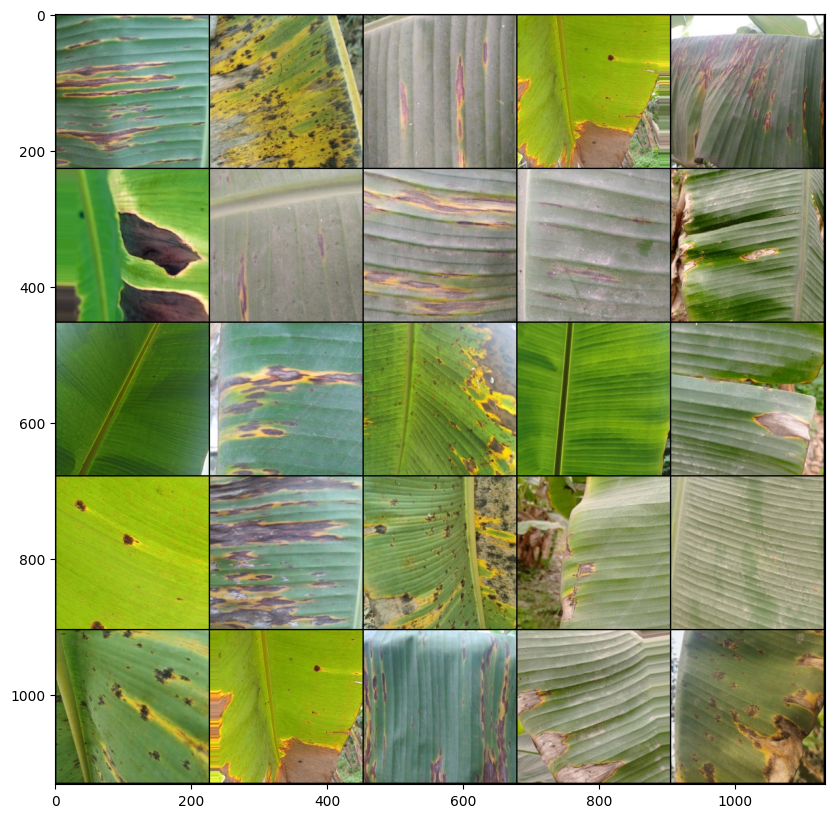

In [10]:
show_dataset(train_dataset_no_transform)

## With Transformation

In [11]:
# Data Transformation
# no need to resize! already resized to 224 x 224 px
train_transform = transforms.Compose([
    # convert images to pytorch tensors
    transforms.ToTensor(), 
    
    # transforms.Normalize(mean=[mean_R, mean_G, mean_B], std=[std_R, std_G, std_B])
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)) 
])

In [12]:
train_dataset = torchvision.datasets.ImageFolder(root=training_dataset_path, transform=train_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.772243..5.1449695].


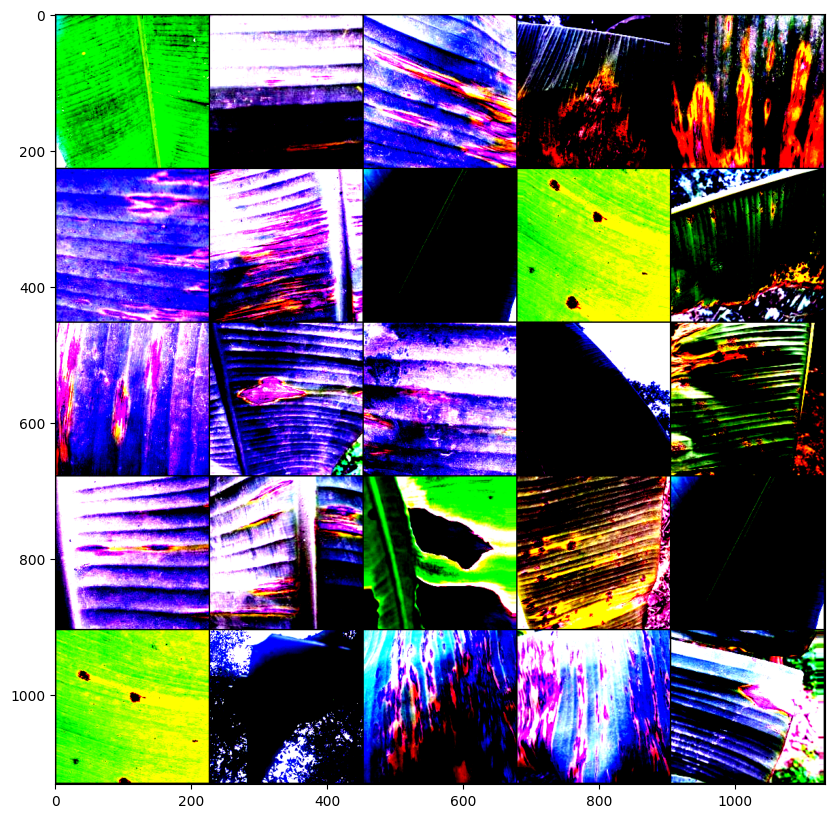

In [13]:
show_dataset(train_dataset)

# Model

In [14]:
# train_loader = transformed and final training dataset 
# Change batch_size depending on the performance of the model
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=False)

In [15]:
os.listdir('../cs180-project/')

['.DS_Store',
 'LICENSE',
 'cs180-proj.ipynb',
 'README.md',
 'train',
 '.ipynb_checkpoints',
 '.git']

## Setup Model

In [16]:
import torchvision.models as models

# chore: change weights to something
resnet152_model = models.resnet152(weights=None)
# Required idownload yung weights/resnet152 weights locally ata 
# so kung wala kayo nun comment nyo muna 3 lines below 
weights_path = "../resnet152-394f9c45.pth"
state_dict = torch.load(weights_path)
resnet152_model.load_state_dict(state_dict)

number_of_features = resnet152_model.fc.in_features
number_of_classes = 4 # healthy, cordona, pestalotiopsis, sigatoka
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet152_model.fc = nn.Linear(number_of_features, number_of_classes)

# Move model to device
resnet152_model = resnet152_model.to(device)

# https://pytorch.org/docs/stable/nn.html#loss-functions 
# try other options
loss_function = nn.CrossEntropyLoss()

# SGD = Stochastic Gradient Descent
# lr = learning rate (test values from [0.001, 0.01] or experiment others)
optimizer = optim.SGD(resnet152_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.003)

## Train Model

In [17]:
def train_neural_network(model, train_loader, test_loader, device, criterion, optimizer, num_epochs):
    
    for epochs in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_loss = running_loss/len(train_loader)
        epoch_accuracy = 100 * running_correct / total if total > 0 else 0

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}%')

    evaluate_model_on_test_set(model, test_loader, device)
    print('training finished')

    return model


## Evaluate Model

In [18]:
def evaluate_model_on_test_set(model, test_loader, device):
    model.eval()

    predicted_correctly_on_epoch = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            predicted_correctly_on_epoch += (labels == predicted).sum().item()

    epoch_accuracy = 100 * running_correct / total if total > 0 else 0
            
    print(f'Got {predicted_correctly_on_epoch} out of {total} images correctly {epoch_accuracy}')
    print('eval finished')

In [ ]:
train_neural_network(resnet152_model, train_loader, train_loader, device, loss_function, optimizer, 100)